In [1]:
from brian2 import *

In [15]:
import matplotlib.pyplot as plt

In [11]:
def randomInput(K, N):
    arr = np.zeros(N)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return arr

Starting simulation at t=0. s for a duration of 1. s
0.8314 s (83%) simulated in 10s, estimated 2s remaining.
1. s (100%) simulated in 12s


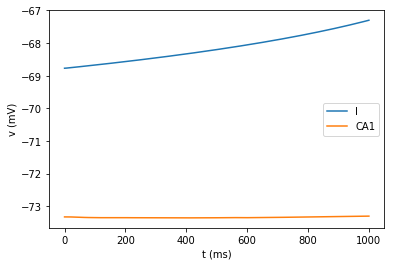

In [18]:
# Parameters
Cm = 1*ufarad
gl = 1e-8*siemens # This was initially 5e-5 siemens

El = -65*mV # Was -60mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens
g_kd = 30*msiemens
VT = -63*mV
# Time constants
taue_r = 5*ms
taue_d = 5*ms

taui_r = 10*ms
taui_d = 10*ms

# Reversal potentials
Ee = 0*mV
Ei = -80*mV
we = 6*nS  # excitatory synaptic weight
wi = -18*nS  # inhibitory synaptic weight, was -67 nS

# The model
eqs = Equations('''
dv/dt = (gl*(El-v)+ge*(Ee-v)+gi*(Ei-v)-
         g_na*(m*m*m)*h*(v-ENa)-
         g_kd*(n*n*n*n)*(v-EK))/Cm : volt
dm/dt = alpha_m*(1-m)-beta_m*m : 1
dn/dt = alpha_n*(1-n)-beta_n*n : 1
dh/dt = alpha_h*(1-h)-beta_h*h : 1

dge/dt = -ge*(1./taue) : siemens
dgi/dt = -gi*(1./taui) : siemens

alpha_m = 0.32*(mV**-1)*(13*mV-v+VT)/
         (exp((13*mV-v+VT)/(4*mV))-1.)/ms : Hz
beta_m = 0.28*(mV**-1)*(v-VT-40*mV)/
        (exp((v-VT-40*mV)/(5*mV))-1)/ms : Hz
alpha_h = 0.128*exp((17*mV-v+VT)/(18*mV))/ms : Hz
beta_h = 4./(1+exp((40*mV-v+VT)/(5*mV)))/ms : Hz
alpha_n = 0.032*(mV**-1)*(15*mV-v+VT)/
         (exp((15*mV-v+VT)/(5*mV))-1.)/ms : Hz
beta_n = .5*exp((10*mV-v+VT)/(40*mV))/ms : Hz
''')

spiking_eqs = Equations('''
dv_/dt = (-v_+inp)/(20*ms) : 1
inp : 1
''')

Pe = NeuronGroup(400, model=spiking_eqs, threshold='v_>1', reset='v_=0', refractory=2*ms,
                method='exponential_euler')

Pi = NeuronGroup(400, model=eqs, threshold='v>-50*mV', refractory=0.5*ms,
                method='exponential_euler')
P_CA1 = NeuronGroup(1, model=eqs, threshold='v>-35*mV', refractory=1*ms,
                method='exponential_euler')

Pe.inp = randomInput(N=400,K=5)
# Pe = P[:400]
# Pi = P[400:440]
# P_CA1 = P[440:]

# print(dir(Pe))
# print(Pe.state)

Ce = Synapses(Pe, P_CA1, on_pre='ge+=we')
Ce_i  = Synapses(Pe, Pi, on_pre='ge+=we')
Ci = Synapses(Pi, P_CA1, on_pre='gi-=wi')

Ce.connect(p=0.2)
Ce_i.connect(p=0.2)
Ci.connect(p=0.2)

Ce.delay = '2*ms'
Ce_i.delay = '1*ms'
Ci.delay = '1*ms'

# Initialization
Pe.v_ = 0
# Pe.v = 'El + (randn() * 5 - 5)*mV'
Pi.v = 'El + (randn() * 5 - 5)*mV'
P_CA1.v = 'El + (randn() * 5 - 5)*mV'

# Record a few traces
trace = SpikeMonitor(Pe, 'v_', record=True)
trace1 = StateMonitor(Pi, 'v', record=True)
trace2 = StateMonitor(P_CA1, 'v', record=True)

run(1 * second, report='text')

fig, ax = plt.subplots()
ax.plot(trace1.t/ms, trace1[0].v/mV, label="I")
ax.plot(trace2.t/ms, trace2[0].v/mV, label="CA1")

# ax1 = fig.add_axes()
# ax1.plot(trace.t/ms, trace.i, c='b', label="CA3")

ax.set_xlabel('t (ms)')
ax.set_ylabel('v (mV)')
plt.legend(loc = 'center right')
plt.show()